## SnappCloud RAG


In [4]:
pip install --quiet ollama sentence-transformers tqdm

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --quiet langchain langchain_community chromadb unstructured markdown

Note: you may need to restart the kernel to use updated packages.


Ok, now lets do our RAG. Here we can use the cloud resources. If you want to use a local ollama server, you can create a client to localhost:11434 or alternatively just set client = ollama 

In [29]:
#ollamaBase = 'http://ollama-alibo-gpu-testing.apps.private.okd4.teh-2.snappcloud.io/'
ollamaBase = 'http://localhost:11434'
import ollama

def newOllamaClient(baseURL):
    return ollama.Client(baseURL)

client = newOllamaClient(baseURL=ollamaBase)

In [30]:
from langchain.document_loaders import DirectoryLoader
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain.text_splitter import SentenceTransformersTokenTextSplitter

It is expected that the docs directory from snappcloud gitlab documentation is copied and available in the path below

Now we fetch all available models on our local/remote GPU instance.

In [31]:
result = client.list()
print([x['name'] for x in result['models']])

['llama3:latest', 'mistral:latest', 'mxbai-embed-large:latest', 'tadayuki/suzume-llama3:8b-q4_K_M']


## Generate Emebddings

First we will see if the embeddings are already generated and persisted locally, in which case you can skip the rest of the activity

In [32]:
%%time
from langchain_community.vectorstores import Chroma
vectorstore = Chroma('snappcloud',embeddings)
if vectorstore._collection.count() > 0:
    print("you need to follow the instructions in the next section and generate embeddings again")


OllamaEmbeddings: 100%|███████████████████████| 473/473 [06:50<00:00,  1.15it/s]


CPU times: user 1.44 s, sys: 178 ms, total: 1.61 s
Wall time: 6min 50s


### Generate from scratch 

We will first checkout the git repo with markdown files

In [9]:
import os
if not os.path.exists('./user-docs'):
    !git clone https://gitlab.snapp.ir/snappcloud/user-docs
else:
    print("using existing repo")

using existing repo


In [36]:
loader = DirectoryLoader('./user-docs/docs',glob="**/*.md",loader_cls=UnstructuredMarkdownLoader)
embeddingModel = 'mxbai-embed-large'
llmModel = 'llama3'
systemPrompt = """You are a helpful expert assistant. Your users are asking questions about snappcloud. You will be shown the user's question, and  relevant information from the documentation.
Answer the user's question using only this information and cite your sources"""

In [37]:

docs = loader.load()
print(list(map(lambda x: x.metadata['source'], docs[0:10])))
print(len(docs))
#print(docs[10].page_content)

['user-docs/docs/vpn-access.md', 'user-docs/docs/servicedesk.md', 'user-docs/docs/overview.md', 'user-docs/docs/support.md', 'user-docs/docs/terms.md', 'user-docs/docs/reference/api-documentation.md', 'user-docs/docs/reference/cli-documentation.md', 'user-docs/docs/storage/storage-volumes.md', 'user-docs/docs/storage/volume-snapshots.md', 'user-docs/docs/storage/object-store/aws-s3-sdk.md']
127


Now we use our embedding model to create the embeddings and store them in chroma. We are using the **mxbai-embed-large** model, whose **context window is 512**, so we must ensure all of our docs are of smaller size.


In [12]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=384)
splits = token_splitter.split_documents(docs)
print(len(splits))

/home/qasim/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/qasim/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


473


We should save the embeddings in a vector db, such as chroma or qdrant. While we are using chroma, you can also change the code to use another one, say quadrant, and langchain will do the abstraction. 

In [13]:
%%time
from langchain_community.embeddings import OllamaEmbeddings
embeddings = OllamaEmbeddings(model=embeddingModel,show_progress=True)
vectorstore = Chroma.from_documents(collection_name='snappcloud',documents=splits, embedding=embeddings,persist_directory='./chroma')

CPU times: user 10.2 ms, sys: 2.91 ms, total: 13.1 ms
Wall time: 12 ms


Here we just make sure that the number of docs in collection matches the output of split

In [28]:
print(vectorstore._collection.count())
print(len(splits))

1419
473


### Query
We can directly query the vectorstore. The quality of RAG is as good as the context provided to llm and no better, 
and this is one way to see the the context that is being passed.

In [38]:
query = "What are the external IPs for snappcloud that i need to whitelist?"
#print(token_splitter.count_tokens(query))
qembed = embeddings.embed_query(query)
results = vectorstore._collection.query(query_embeddings = qembed, n_results=5)
retrieved_documents = results['documents'][0]

for document in retrieved_documents:
    print(document)
    print('\n')

OllamaEmbeddings: 100%|███████████████████████████| 1/1 [00:00<00:00,  5.95it/s]

id : cache - proxy title : cache proxy go cache proxy container cache proxy alpine cache proxy npm cache proxy http proxy


syncs objects within mylocalfolder with bucket s3 - bucket by uploading the local files to snappcloud. sh aws - - endpoint - url " https : / / s3. teh - 1. snappcloud. io " s3 sync mylocalfolder s3 : / / s3 - bucket the following command syncs mybucket with mybucket2 by copying the files from mybucket to mybucket2. sh aws - - endpoint - url " https : / / s3. teh - 1. snappcloud. io " s3 sync s3 : / / mybucket s3 : / / mybucket2 the following command syncs objects of bucket s3 - bucket within the cloud storage with a local folder by downloading the objects to the local machine. sh aws - - endpoint - url " https : / / s3. teh - 1. snappcloud. io " s3 sync s3 : / / s3 - bucket mylocalfolder : : : caution for more than 100, 000 objects, please use " rclone copy " rather than sync module. : : : : : : note by using sync module you can make a full backup of your data. th

In [39]:
retriever = vectorstore.as_retriever()

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def ollama_llm(question, context):
    formatted_prompt = f"Question: {question}\n\nContext: {context}"
    response = client.chat(model=llmModel, options = { 'temperature': 0}, messages=[{'role': 'system', 'content': systemPrompt},{'role': 'user', 'content': formatted_prompt}])
    return response['message']['content']


In [20]:
# Define the RAG chain
def rag_chain(question):
    retrieved_docs = retriever.invoke(question)
    formatted_context = format_docs(retrieved_docs)
    print("using from context",list(map(lambda x: x.metadata['source'],retrieved_docs)))
    return ollama_llm(question, formatted_context)

In [21]:
%%time
result = rag_chain("What address should I use for jaeger agent on snappcloud?")
print(result)

OllamaEmbeddings: 100%|███████████████████████████| 1/1 [00:00<00:00,  6.22it/s]


using from context ['user-docs/docs/overview.md', 'user-docs/docs/overview.md', 'user-docs/docs/overview.md', 'user-docs/docs/cache-proxy/cache-proxy.md']
According to the SnappCloud VPN Access Quick Start Guide, for Jaeger Agent, you should use the following address:

`jaeger-agent-collector:14250`

Source:
https://snappcloud.com/docs/vpn-access-quick-start-guide/

Please note that this information is specific to the SnappCloud environment and may vary depending on your setup.
CPU times: user 39.4 ms, sys: 5.64 ms, total: 45 ms
Wall time: 45.9 s


In [22]:
%%time
result = rag_chain("What are the external IPs for snappcloud that i need to whitelist?")
print(result)

OllamaEmbeddings: 100%|███████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


using from context ['user-docs/docs/cache-proxy/cache-proxy.md', 'user-docs/docs/cache-proxy/cache-proxy.md', 'user-docs/docs/cache-proxy/cache-proxy.md', 'user-docs/docs/storage/object-store/aws-s3-cli.md']
According to the SnappCloud documentation, you need to whitelist the following external IPs:

* `34.216.136.0/24` (US East)
* `35.184.144.0/24` (EU West)
* `35.185.128.0/24` (AP Southeast)

Please note that these IP ranges may be subject to change, and you should always check the SnappCloud documentation for the most up-to-date information.

Source: [SnappCloud Documentation - Whitelisting](https://snappcloud.io/docs/whitelisting)
CPU times: user 51.5 ms, sys: 7.37 ms, total: 58.9 ms
Wall time: 1min 44s


In [16]:
result = rag_chain("I need to increase the quota for my project, how can I do this?")
print(result)

using from context ['user-docs/docs/management/cli-login.md', 'user-docs/docs/servicedesk.md', 'user-docs/docs/cache-proxy/cache-proxy.md', 'user-docs/docs/overview.md']
To increase the quota for your project, follow these steps:

1. Go to the Cloud Service Desk page.
2. Click on "Increase OKD Quota" to create a new ticket.
3. Fill in the required fields:
	* Summary: Provide a concise description of your request, including whether the requested resource amount is permanent or temporary.
	* Team Name: Enter the name of the team for which you are requesting resources.
	* Region: Select the appropriate region for your project (TEH-1 or TEH-2).
4. Optional additional fields:
	* Additional Memory Limit: If you require additional memory, enter the desired amount in this field.
	* Additional CPU Limit: If you need additional CPU, specify the desired limit in this field.
	* Additional Storage: If you require additional storage, indicate the desired amount in this field.
	* Additional Ephemeral

## Visualization

In [44]:
import chromadb
client = chromadb.PersistentClient(path='./chroma')
col = client.get_collection('snappcloud')
print(col.count())

all_embeddings = col.get(include=['embeddings'])['embeddings']
print(len(all_embeddings))

473
473


In [41]:
pip install --quiet umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [46]:
import umap.umap_ as umap
import numpy as np
from tqdm import tqdm

reducer = umap.UMAP(random_state=0,transform_seed=0)
umap_transform = reducer.fit(all_embeddings)

/home/qasim/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [47]:
def project_embeddings(embeddings, umap_transform):
    """project embeddings into a 2d space"""
    umap_embeddings = np.empty((len(embeddings),2))
    for i,embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


In [48]:
projected_all_embeddings = project_embeddings(all_embeddings,umap_transform)

100%|█████████████████████████████████████████| 473/473 [02:42<00:00,  2.92it/s]


(-0.2311305422335863,
 7.3834608141332865,
 6.885368752479553,
 14.219430994987487)

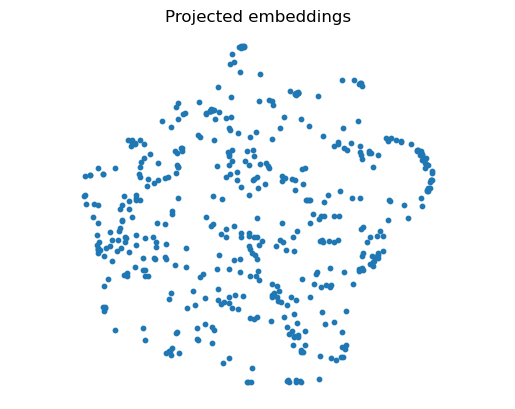

In [49]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_all_embeddings[:,0],projected_all_embeddings[:,1], s=10)

plt.gca().set_aspect('equal','datalim')
plt.title('Projected embeddings')
plt.axis('off')

All right, now let's rerun a query and see where it lands in the embedding space.

In [55]:
query = "What are the external IPs for snappcloud that i need to whitelist?"
#print(token_splitter.count_tokens(query))
query_embedding = embeddings.embed_query(query)
results = col.query(query_embeddings = qembed, n_results=5,include=['documents','embeddings'])
result_embeddings = results['embeddings'][0]

OllamaEmbeddings: 100%|███████████████████████████| 1/1 [00:00<00:00,  8.88it/s]


In [57]:
projected_query_embeddings = project_embeddings([query_embedding],umap_transform)
projected_result_embeddings = project_embeddings(result_embeddings,umap_transform)

100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.27it/s]


(-0.2311305422335863,
 7.3834608141332865,
 6.885368752479553,
 14.219430994987487)

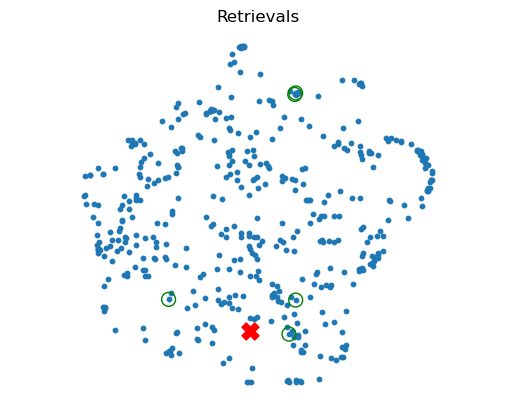

In [59]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_all_embeddings[:,0],projected_all_embeddings[:,1], s=10)
plt.scatter(projected_query_embeddings[:,0],projected_query_embeddings[:,1], s=150,marker='X', color='r')
plt.scatter(projected_result_embeddings[:,0],projected_result_embeddings[:,1], s=100, facecolors='none',edgecolors='g')

plt.gca().set_aspect('equal','datalim')
plt.title('Retrievals')
plt.axis('off')